# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [1]:
# Put this in this file to have imported models reload automatically when you edit them.
!cat ~/.ipython/profile_default/startup/00-autoreload.ipy

%load_ext autoreload
%autoreload 2

In [2]:
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [3]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

# pytorch datasets that download MNIST set as needed; used only to download files
train_dset = dsets.MNIST(root=data_path, download=False, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=False, train=False, transform=trans)

In [4]:
# Tweaks to the data sets

# Hack to turn a dataset into two lists
Xtest, ytest = list(zip(*test_dset))

# This turns a list of N A*B tensors into an N*A*B tensor
Xtest = torch.stack(Xtest)

# This turns a list into a tensor, and ensures they stay as integers (no conversion to floats!)
ytest = torch.LongTensor(ytest)

In [5]:
from torch.utils.data import DataLoader

# create dataloaders
batch_size = 64

train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
#test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [40]:
# Testing ways to split up the data by value. May have to make custom datasets


#print(train_dset)
#print(type(train_dset.targets.where(torch.tensor([8]), torch.tensor([0]))))

#lengths = [6000 for i in range(10)]
#print(lengths)
#splits = torch.utils.data.random_split(train_dset, 6000)

#print(train_dset.__getitem__(0))
#print(type(train_dset.__getitem__(0)))
#print(train_dset.__getitem__(0)[1])


# get a list of the label values from the training dataset
label_values = []
for i in range(len(train_dset)):
    label_values.append(train_dset[i][1])

#print(label_values)
print(len(label_values))

60000


In [7]:
# Create subsets for the workers

from torch.utils.data.dataset import Subset

train_targets = [[],[],[],[],[],[],[],[],[],[]]




train_subset_zeros = Subset(train_dset, train_targets[0])
train_subset_ones = Subset(train_dset, train_targets[1])
train_subset_twos = Subset(train_dset, train_targets[2])
train_subset_threes = Subset(train_dset, train_targets[3])
train_subset_fours = Subset(train_dset, train_targets[4])
train_subset_fives = Subset(train_dset, train_targets[5])
train_subset_sixes = Subset(train_dset, train_targets[6])
train_subset_sevens = Subset(train_dset, train_targets[7])
train_subset_eights = Subset(train_dset, train_targets[8])
train_subset_nines = Subset(train_dset, train_targets[9])


"""
test_targets = [[],[],[],[],[],[],[],[],[],[]]

test_subset_zeros = Subset(test_dset, test_targets[0])
test_subset_ones = Subset(test_dset, test_targets[1])
test_subset_twos = Subset(test_dset, test_targets[2])
test_subset_threes = Subset(test_dset, test_targets[3])
test_subset_fours = Subset(test_dset, test_targets[4])
test_subset_fives = Subset(test_dset, test_targets[5])
test_subset_sixes = Subset(test_dset, test_targets[6])
test_subset_sevens = Subset(test_dset, test_targets[7])
test_subset_eights = Subset(test_dset, test_targets[8])
test_subset_nines = Subset(test_dset, test_targets[9])
"""

print(train_subset_eights.dataset)
print(train_targets[8])

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./MNIST-data/raw
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(1.0,))
                         )
    Target Transforms (if any): None
[]


In [8]:
#


train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)

In [9]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

model = MLPNet()

learning_rate = 1e-1
momentum = 0.5
num_epochs = 5

# no momentum for like-with-like test
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):

    for batch_idx, (x, target) in enumerate(train_dloader):
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target)
        train_loss_history.append(loss.item())
        if batch_idx%100 == 0:
            print(batch_idx, train_loss_history[-1])
        loss.backward()
        optimizer.step()
        
    # only do this once per epoch. Expensive.
    # (Although it makes it difficult to show two loss curves on same plot, as you saw)
    with torch.no_grad():
        
        test_loss_history.append(criterion(model(Xtest), ytest).item())
        print("-->", epoch, test_loss_history[-1])

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_loss_history, label="train")
ax[0].set_xlabel("batches")
ax[1].plot(test_loss_history, label="test")
ax[1].set_xlabel("epochs")
ax[0].legend()
ax[1].legend();

## Testing Federation

Up to this point, we've trained an MNIST model with pytorch with no fancy business. Now we add federation.

In [10]:
import federated

learning_rate = 1e-2
num_epochs = 1

# momentum = 0.5 # TODO: do we need it? If so, how and where to pass it through?

datasets = [train_dloader,
            train_dloader,
            
           ]

manager = federated.FederatedManager(
    datasets,
    MLPNet(),
    nn.CrossEntropyLoss(),
    learning_rate,
    Xtest,
    ytest,
    num_epochs
)

In [11]:
from tqdm import tqdm

print("Training", num_epochs, "round(s) with", manager.n_workers, "worker(s)")

for i in tqdm(range(num_epochs)):
    print("Beginning round", i)
    manager.round()
    print("    Round: %03d" % i, "Loss: %.5f" % manager.manager_loss_history[-1])

  0%|          | 0/1 [00:00<?, ?it/s]

Training 1 round(s) with 2 worker(s)
Beginning round 0
Worker: 98208 Batch: 00000 Loss: 2.31055
Worker: 98208 Batch: 00100 Loss: 2.22383
Worker: 98208 Batch: 00200 Loss: 2.15188
Worker: 98208 Batch: 00300 Loss: 1.99532
Worker: 98208 Batch: 00400 Loss: 1.53270
Worker: 98208 Batch: 00500 Loss: 1.26825
Worker: 98208 Batch: 00600 Loss: 1.01252
Worker: 98208 Batch: 00700 Loss: 0.91249
Worker: 98208 Batch: 00800 Loss: 0.74616
Worker: 98208 Batch: 00900 Loss: 0.54817
Worker: 98152 Batch: 00000 Loss: 0.55944
Worker: 98152 Batch: 00100 Loss: 0.80053
Worker: 98152 Batch: 00200 Loss: 0.58617
Worker: 98152 Batch: 00300 Loss: 0.66774
Worker: 98152 Batch: 00400 Loss: 0.58213
Worker: 98152 Batch: 00500 Loss: 0.58634
Worker: 98152 Batch: 00600 Loss: 0.37660
Worker: 98152 Batch: 00700 Loss: 0.39704
Worker: 98152 Batch: 00800 Loss: 0.21059
Worker: 98152 Batch: 00900 Loss: 0.35807


100%|██████████| 1/1 [00:23<00:00, 23.97s/it]

    Round: 000 Loss: 0.39071


2


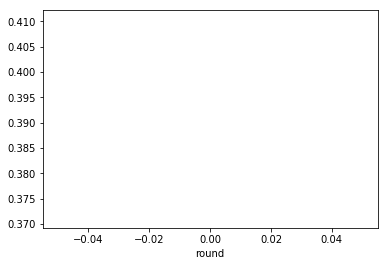

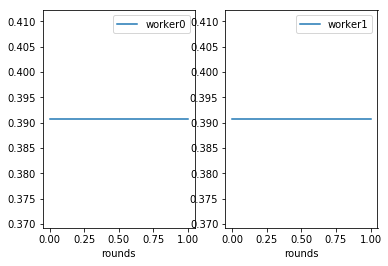

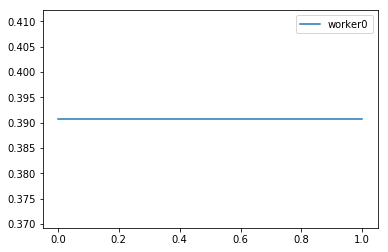

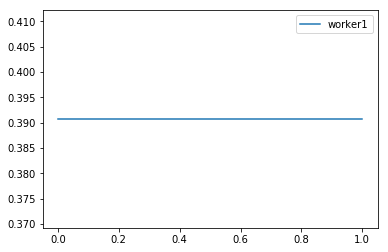

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="global loss")
ax.set_xlabel("round");


fig, ax = plt.subplots(1, 2)
ax[0].plot(manager.worker_loss_histories[0], label="worker0")
ax[0].set_xlabel("rounds")
ax[1].plot(manager.worker_loss_histories[1], label="worker1")
ax[1].set_xlabel("rounds")
ax[0].legend()
ax[1].legend();

#fig, ax = plt.subplots()

print(len(manager.worker_loss_histories))

for i in range(len(manager.worker_loss_histories)):
    
    fig, ax = plt.subplots()
    lbl = "worker" + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();

#ax.legend();

#TODO Get the plots correct